In [78]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import coint
import numpy as np
from scipy import signal

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
with open('/content/drive/MyDrive/TU/dex_WETHUSDT.pkl', 'rb') as f:
    dex = pickle.load(f)

with open('/content/drive/MyDrive/TU/ETHUSDT.pkl', 'rb') as f:
    cex = pickle.load(f)

merged = cex.merge(dex, left_index=True, right_index=True, suffixes=('_cex', '_dex'))

# **1. Calculating moving avarage**

In [80]:
merged['moving_avg_dex'] = merged['close_dex'].rolling(window=5).mean()
merged['moving_avg_cex'] = merged['close_cex'].rolling(window=5).mean()

# Min-Max Normalization
merged['moving_avg_cex_normalized'] = (merged['moving_avg_cex'] - merged['moving_avg_cex'].min()) / (merged['moving_avg_cex'].max() - merged['moving_avg_cex'].min())
merged['moving_avg_dex_normalized'] = (merged['moving_avg_dex'] - merged['moving_avg_dex'].min()) / (merged['moving_avg_dex'].max() - merged['moving_avg_dex'].min())

#merged = merged.resample('H').mean()
start_time = '2022-01-09 12:00:00'
end_time = '2022-01-09 23:59:00'
merged = merged.loc[start_time:end_time]

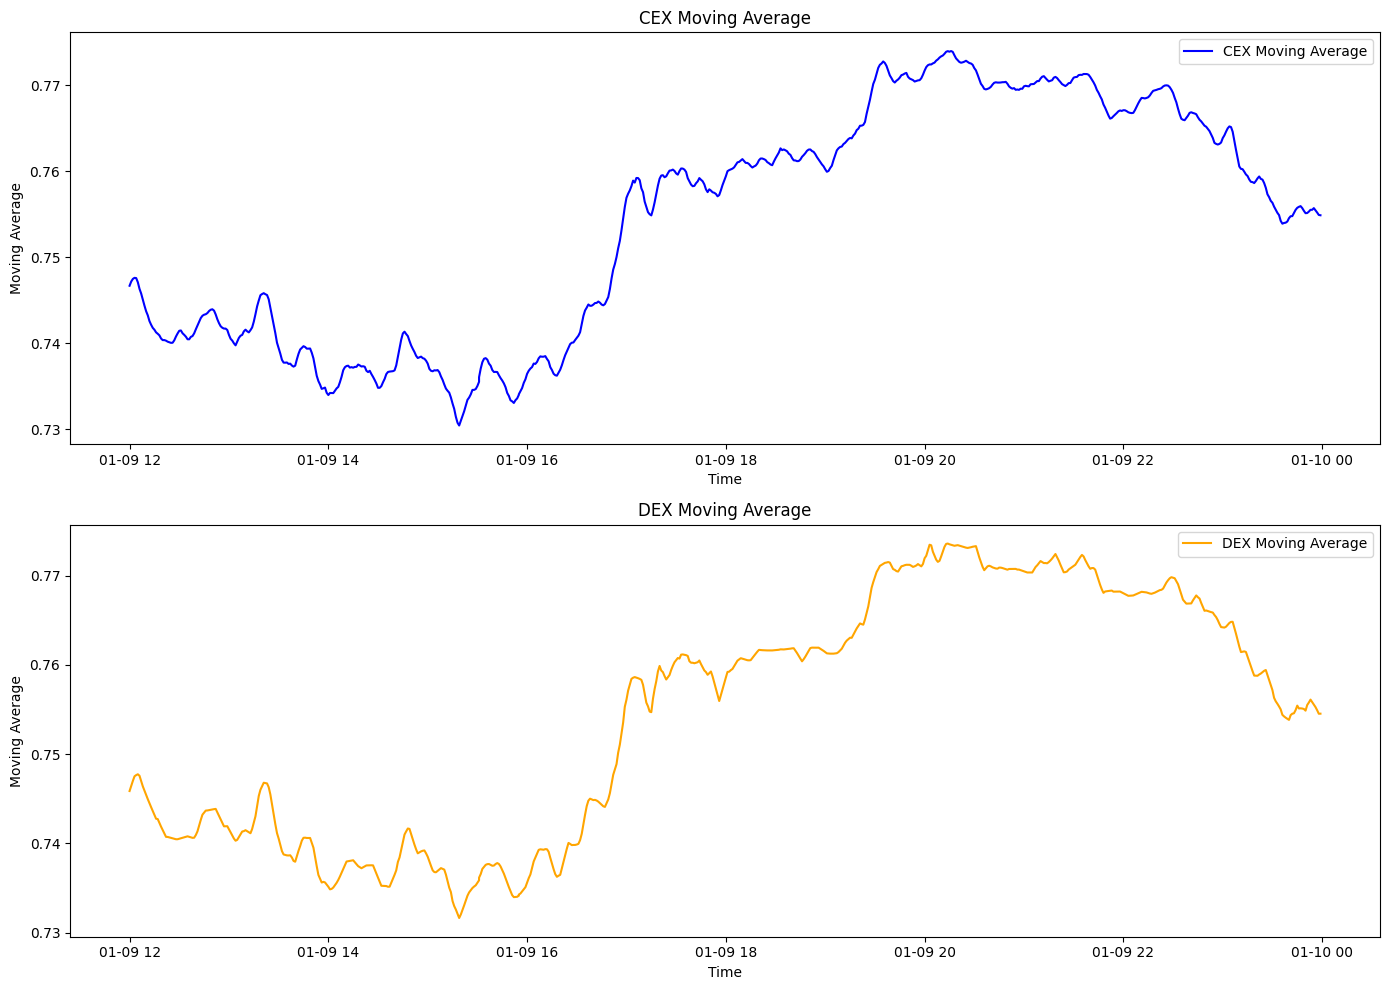

In [81]:
fig, axs = plt.subplots(2, figsize=(14, 10))
axs[0].plot(merged.loc[start_time:end_time].index, merged.loc[start_time:end_time]['moving_avg_cex_normalized'], label='CEX Moving Average', color='blue')
axs[1].plot(merged.loc[start_time:end_time].index, merged.loc[start_time:end_time]['moving_avg_dex_normalized'], label='DEX Moving Average', color='orange')
axs[0].set_title('CEX Moving Average')
axs[1].set_title('DEX Moving Average')
for ax in axs:
    ax.set_xlabel('Time')
    ax.set_ylabel('Moving Average')
    ax.legend()

plt.tight_layout()
plt.show()

The movement from January 15th to April 1st seem to deviate from each other strongly with a suspisious difference in trends, highs and lows

# **2. Correlation coefficient of percentage change**

In [82]:
merged['pct_change_cex'] = merged['moving_avg_cex'].pct_change()
merged['pct_change_dex'] = merged['moving_avg_dex'].pct_change()

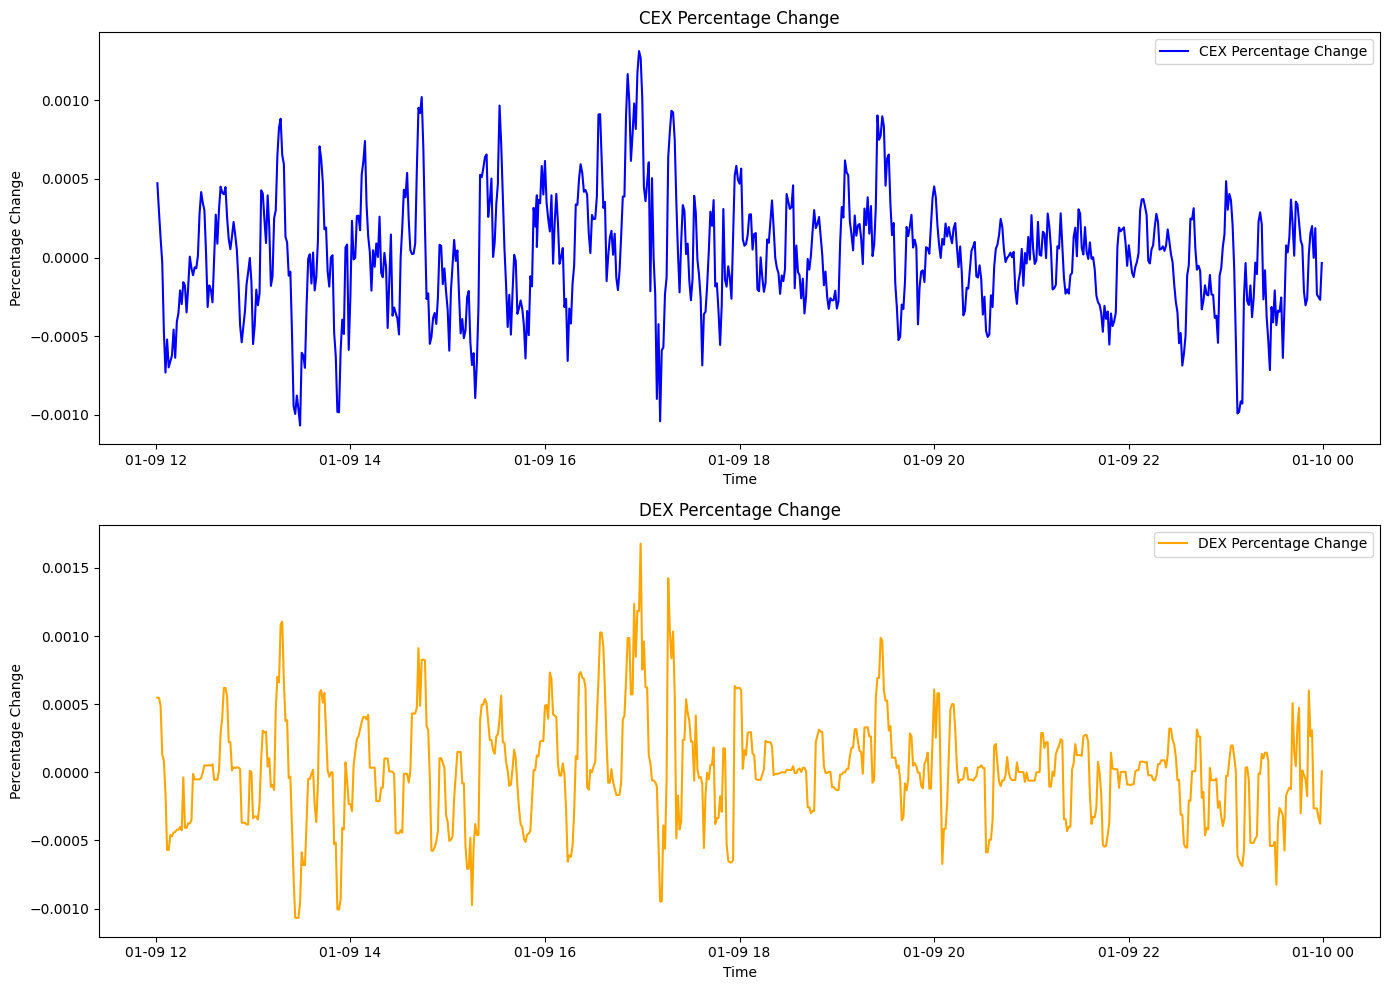

In [83]:
fig, axs = plt.subplots(2, figsize=(14, 10))
axs[0].plot(merged.loc[start_time:end_time].index, merged.loc[start_time:end_time]['pct_change_cex'], label='CEX Percentage Change', color='blue')
axs[1].plot(merged.loc[start_time:end_time].index, merged.loc[start_time:end_time]['pct_change_dex'], label='DEX Percentage Change', color='orange')
axs[0].set_title('CEX Percentage Change')
axs[1].set_title('DEX Percentage Change')
for ax in axs:
    ax.set_xlabel('Time')
    ax.set_ylabel('Percentage Change')
    ax.legend()

plt.tight_layout()
plt.show()

In [84]:
def calculate_correlation(merged, start_date, end_date):
    start_time = pd.to_datetime(start_date)
    end_time = pd.to_datetime(end_date)

    correlation_values = []
    current_time = start_time

    while current_time <= end_time:
        end_time_interval = current_time + pd.Timedelta(minutes=10)
        
        correlation = merged.loc[current_time:end_time_interval, 'moving_avg_cex_normalized'].dropna().corr(merged.loc[current_time:end_time_interval, 'moving_avg_dex_normalized'].dropna())
        print(f'Correlation coefficient for period starting {current_time}:', correlation)
        
        correlation_values.append(correlation)
        current_time += pd.Timedelta(minutes=10)

    return correlation_values


### Correlation coefficient

In [85]:
correlation = merged['moving_avg_cex_normalized'].dropna().corr(merged['moving_avg_dex_normalized'].dropna())
print('Correlation coefficient:', correlation)

Correlation coefficient: 0.9982501382739845


In [86]:
coef = calculate_correlation(merged, start_time, end_time)

Correlation coefficient for period starting 2022-01-09 12:00:00: 0.7250866031999178
Correlation coefficient for period starting 2022-01-09 12:10:00: 0.990573231397112
Correlation coefficient for period starting 2022-01-09 12:20:00: -0.28625868197901333
Correlation coefficient for period starting 2022-01-09 12:30:00: -0.1613607849108627
Correlation coefficient for period starting 2022-01-09 12:40:00: 0.9800109778448873
Correlation coefficient for period starting 2022-01-09 12:50:00: 0.9544076519625668
Correlation coefficient for period starting 2022-01-09 13:00:00: 0.8712258472684545
Correlation coefficient for period starting 2022-01-09 13:10:00: 0.9938596524954911
Correlation coefficient for period starting 2022-01-09 13:20:00: 0.9973064952789079
Correlation coefficient for period starting 2022-01-09 13:30:00: 0.983118275831231
Correlation coefficient for period starting 2022-01-09 13:40:00: 0.9539421848254452
Correlation coefficient for period starting 2022-01-09 13:50:00: 0.99603590

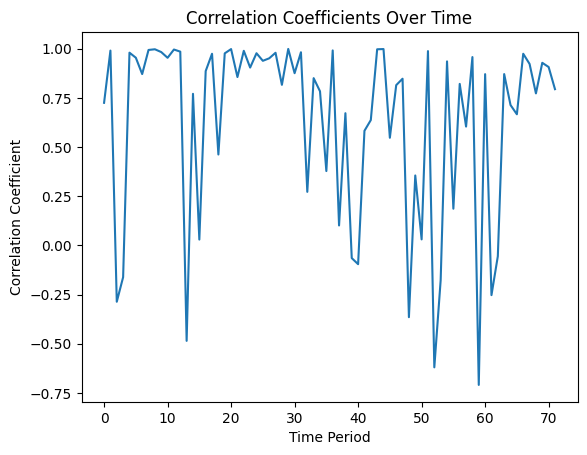

In [87]:
plt.plot(coef)
plt.title('Correlation Coefficients Over Time')
plt.xlabel('Time Period')
plt.ylabel('Correlation Coefficient')
plt.show()

# **3. Cross-Correlation**

Cross-correlation is a measure of similarity of two time series as a function of the displacement of one relative to the other. This is also known as a sliding dot product or sliding inner-product. It is commonly used for searching a long-duration signal for a shorter, known feature. 

<ipython-input-135-7573ed8afb9b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,1,3)


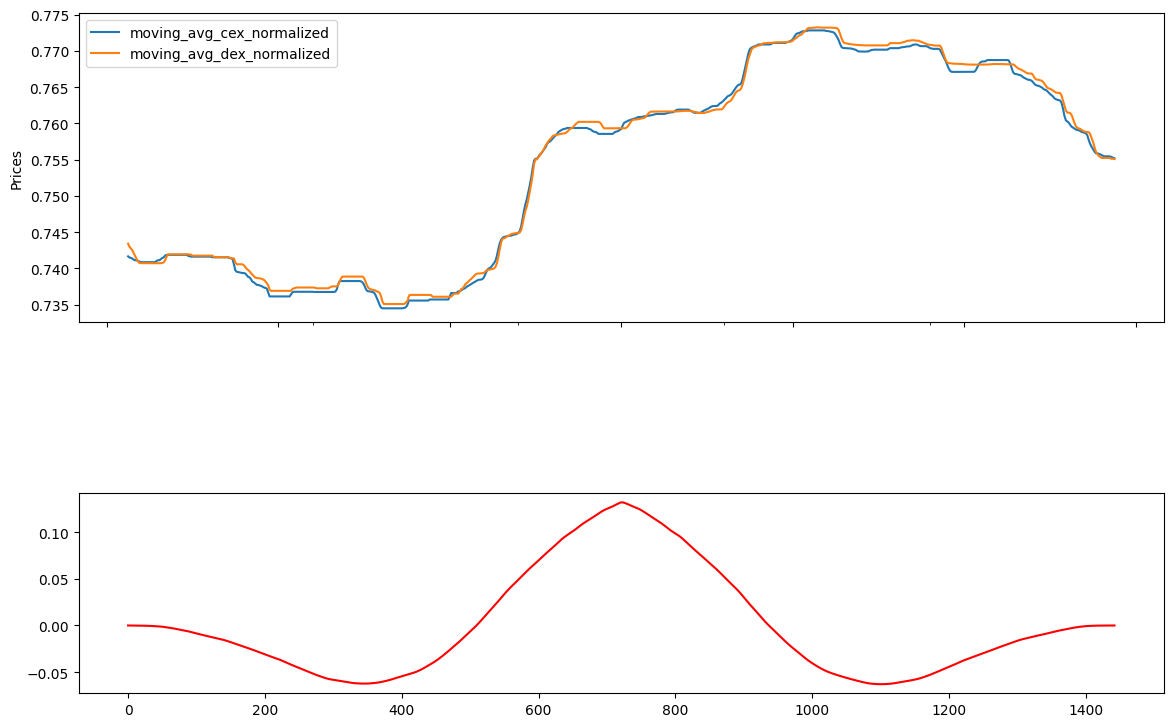

In [135]:
f,ax=plt.subplots(2,1,figsize=(14,10),sharex=True)
merged.iloc[:, [11, 12]].rolling(window=30,center=True).median().plot(ax=ax[0])
ax[0].set(xlabel='Frame',ylabel='Prices')
plt.subplot(3,1,3)
plt.plot(correlation, 'r')

plt.savefig('plot.png', dpi=300)

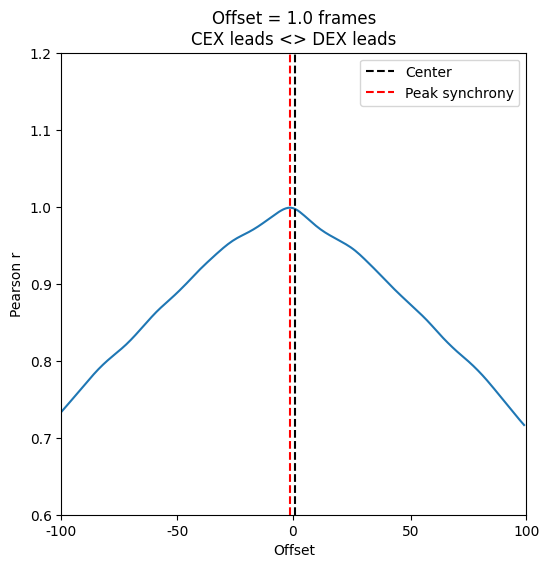

In [199]:
def crosscorr(datax, datay, lag=0, wrap=False):
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))


seconds = 1
fps = 100
rs = [crosscorr(merged['moving_avg_cex_normalized'],merged['moving_avg_dex_normalized'], lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
offset = np.floor(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(6,6))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {offset} frames\nCEX leads <> DEX leads',ylim=[.6,1.2],xlim=[10,80], xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 50, 100, 151, 201])
ax.set_xticklabels([-100, -50, 0, 50, 100]);
plt.legend()
plt.savefig('offset.png', dpi=300)

Subtracting the mean from the inputs and calculating the correlation lag period with 1D cross-correlation

In [88]:
y = merged['moving_avg_cex_normalized']
x = merged['moving_avg_dex_normalized']
correlation = signal.correlate(x-np.mean(x), y - np.mean(y), mode="full")
lags = signal.correlation_lags(len(x), len(y), mode="full")
lag = lags[np.argmax(abs(correlation))]
print(lag)

1


# **4. Pearson correlation**

Text(0.5, 0.98, 'Smiling data and rolling window correlation')

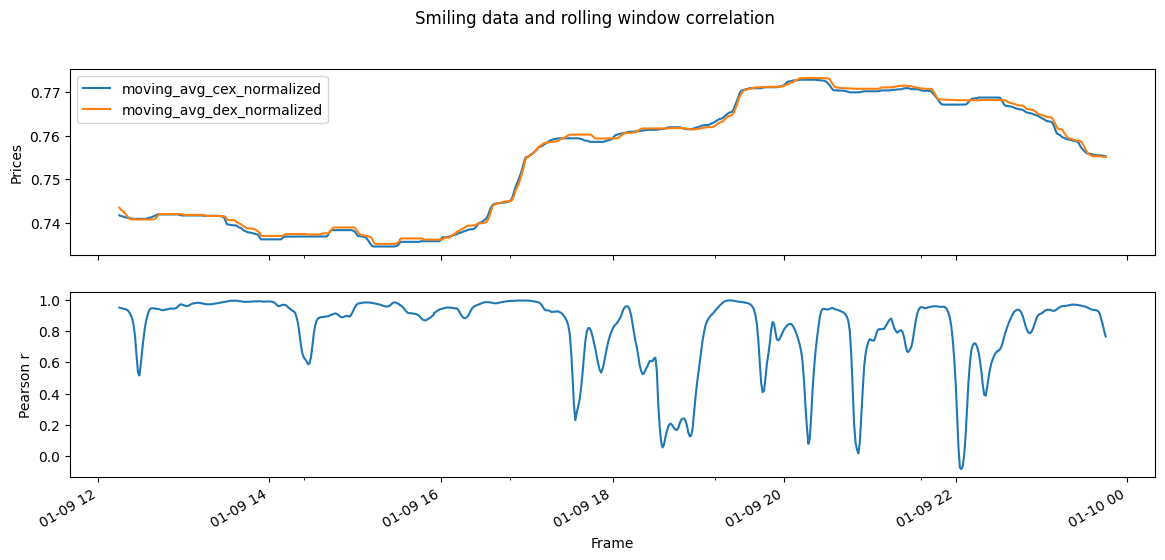

In [91]:
y = merged['moving_avg_cex_normalized']
x = merged['moving_avg_dex_normalized']

# Set window size to compute moving window synchrony.
r_window_size = 30

# Compute rolling window synchrony
rolling_r = x.rolling(window=r_window_size, center=True).corr(y)
f,ax=plt.subplots(2,1,figsize=(14,6),sharex=True)
merged.iloc[:, [11, 12]].rolling(window=30,center=True).median().plot(ax=ax[0])
ax[0].set(xlabel='Frame',ylabel='Prices')
rolling_r.plot(ax=ax[1])
ax[1].set(xlabel='Frame',ylabel='Pearson r')
plt.suptitle("Smiling data and rolling window correlation")

# **5. Dynamic Time Warping**


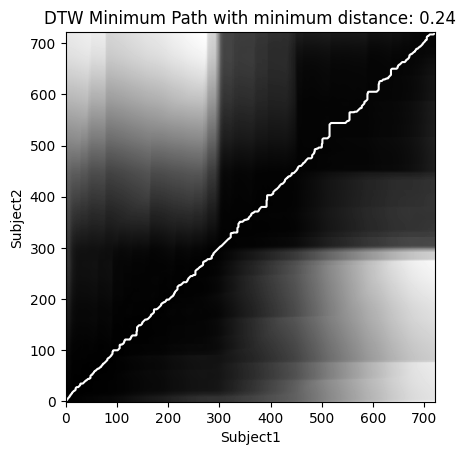

In [102]:
# !pip install dtw
from dtw import dtw,accelerated_dtw

d1 = merged['moving_avg_cex_normalized'].interpolate().values
d2 = merged['moving_avg_dex_normalized'].interpolate().values
d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(d1,d2, dist='euclidean')

plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.xlabel('Subject1')
plt.ylabel('Subject2')
plt.title(f'DTW Minimum Path with minimum distance: {np.round(d,2)}')
plt.show()